Tần số mẫu (sample rate): 44100
Độ dài tín hiệu: 19715328 mẫu


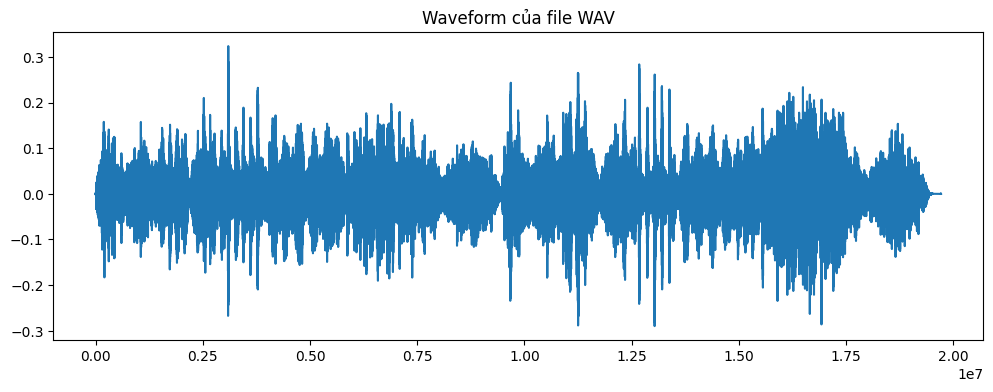

In [153]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Đọc file WAV và lấy mẫu âm thanh
file_path = '../Data/MusicNet_Dataset/musicnet/musicnet/train_data/1727.wav'

y, sr = librosa.load(file_path, sr=44100)

print(f"Tần số mẫu (sample rate): {sr}")
print(f"Độ dài tín hiệu: {len(y)} mẫu")

# Hiển thị waveform
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title('Waveform của file WAV')
plt.show()

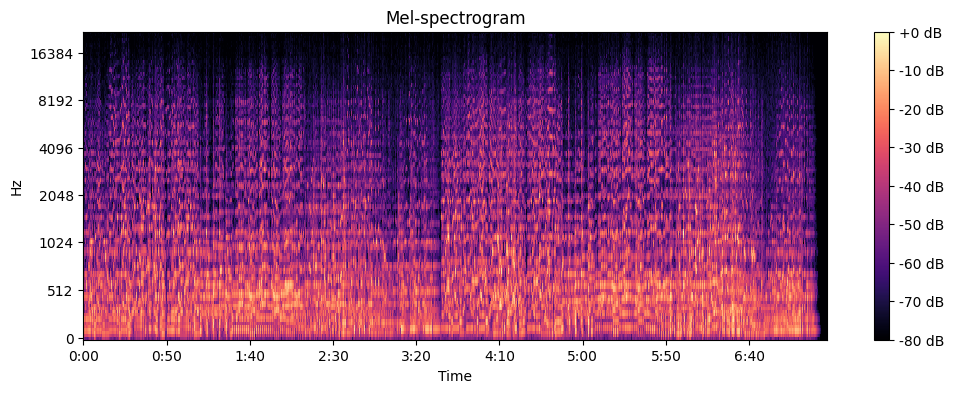

Kích thước đặc trưng Mel: (128, 38507)


In [154]:
# Chuyển đổi thành Mel-spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

# Đưa về thang đo dB để dễ quan sát hơn
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Hiển thị Mel-spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.show()

print(f"Kích thước đặc trưng Mel: {mel_spec_db.shape}")

In [155]:
import pandas as pd

csv_path = '../Data/MusicNet_Dataset/musicnet/musicnet/train_labels/1727.csv'

df = pd.read_csv(csv_path)
print(df.head())

   start_time  end_time  instrument  note  start_beat  end_beat  \
0        9182     90078          43    53         4.0       1.5   
1        9182     33758          42    65         4.0       0.5   
2        9182     62430           1    69         4.0       1.0   
3        9182    202206          44    41         4.0       3.5   
4        9182     62430           1    81         4.0       1.0   

       note_value  
0  Dotted Quarter  
1          Eighth  
2         Quarter  
3           Whole  
4         Quarter  


In [156]:
def create_windows(spec, window_size=128, step=64):
    windows = []
    for i in range(0, spec.shape[1] - window_size, step):
        windows.append(spec[:, i:i + window_size])
    return np.array(windows)

X_train = create_windows(mel_spec_db)
print(f"Kích thước dữ liệu sau khi chia: {X_train.shape}")

Kích thước dữ liệu sau khi chia: (600, 128, 128)


In [157]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2


model = models.Sequential([
    layers.Input(shape=(128, 128, 1)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),  

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Block 3 (Thêm tầng sâu hơn để học đặc trưng phức tạp hơn)
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
# 128 nốt + 1 class "không có nốt"
    layers.Dense(129, activation='softmax')  
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 129)            │        33,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,515,585 (32.48 MB)

 Trainable params: 8,515,137 (32.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [158]:
import librosa

y, sr = librosa.load(file_path, sr=44100)

# Chuyển đổi thời gian (micro giây) thành frame trong Mel-spectrogram
def time_to_frame(time, sr, hop_length):
    return int((time / 1000000) * sr // hop_length)

# Tạo Mel-spectrogram
hop_length = 512
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=hop_length)

print("Kích thước Mel-spectrogram:", mel_spec.shape)

# Chuyển đổi thời gian thành frame
df['start_frame'] = df['start_time'].apply(lambda x: time_to_frame(x, sr, hop_length))
df['end_frame'] = df['end_time'].apply(lambda x: time_to_frame(x, sr, hop_length))

# Khởi tạo mảng nhãn với giá trị -1 (không có nốt nhạc)
y_train = np.full(mel_spec.shape[1], -1)

# Gán nốt nhạc theo frame
for _, row in df.iterrows():
    start, end, note = row['start_frame'], row['end_frame'], row['note']
    y_train[start:end] = note

# Kiểm tra kết quả
print("Dữ liệu y_train (nốt nhạc tương ứng với mỗi frame):", y_train[:50])
print(f"Kích thước X_train: {mel_spec.shape}")
print(f"Kích thước y_train: {y_train.shape}")


Kích thước Mel-spectrogram: (128, 38507)
Dữ liệu y_train (nốt nhạc tương ứng với mỗi frame): [81 81 60 60 60 72 72 57 57 57 62 62 64 64 53 79 65 65 77 79 79 60 60 48
 48 48 80 80 41 41 89 89 81 82 82 86 86 80 81 81 84 84 48 48 48 60 82 52
 52 52]
Kích thước X_train: (128, 38507)
Kích thước y_train: (38507,)


In [159]:
def create_windowshow(X, y, window_size=128, step=64):
    X_windows, y_windows = [], []
    max_index = X.shape[1] - window_size

    for i in range(0, max_index + 1, step):
        # Cắt cửa sổ từ X
        X_windows.append(X[:, i:i + window_size])
        
        # Tính chỉ số trung tâm cho nhãn
        center_index = i + window_size // 2
        
        # Kiểm tra chỉ số trung tâm không vượt quá kích thước y
        if center_index < len(y):
            y_windows.append(y[center_index])
    
    return np.array(X_windows), np.array(y_windows)


# Tạo cửa sổ từ mel_spec và y_train
X_train, y_train = create_windowshow(mel_spec, y_train)

# Chuyển đổi -1 thành 88 (đánh dấu vùng không có nốt nhạc)
y_train[y_train == -1] = 128

# Kiểm tra kích thước và xác nhận không còn giá trị -1
print("Kích thước X_train:", X_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Giá trị duy nhất trong y_train:", np.unique(y_train))

# Huấn luyện mô hình 
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Kích thước X_train: (600, 128, 128)
Kích thước y_train: (600,)
Giá trị duy nhất trong y_train: [ 37  44  50  53  57  60  61  63  65  66  67  69  70  71  72  80 128]
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.6103 - loss: 4.2550 - val_accuracy: 1.0000 - val_loss: 0.3778
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - accuracy: 0.9057 - loss: 1.1937 - val_accuracy: 1.0000 - val_loss: 0.2078
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.9459 - loss: 0.5859 - val_accuracy: 1.0000 - val_loss: 0.1509
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.9409 - loss: 0.3368 - val_accuracy: 1.0000 - val_loss: 0.0391
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step - accuracy: 0.9513 - loss: 0.3053 - val_accuracy: 1.0000 - val_loss: 0.0240
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 821ms/step - accuracy: 0.9581 - loss: 0.1911 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 470ms/step - accuracy: 0.9572 - loss: 0.